In [1]:
import pint
import xarray as xr
from dask.distributed import Client
from seapopym.configuration.no_transport.parameter import ForcingParameters
from seapopym.configuration.parameters.parameter_forcing import ForcingUnit
from seapopym.standard.units import StandardUnitsLabels

from seapopym_optimization import (
    FunctionalGroupOptimizeNoTransport,
    GeneticAlgorithm,
    GeneticAlgorithmParameters,
    NoTransportCostFunction,
    Observation,
    Parameter,
    constraint,
)

%load_ext autoreload

Load forcing.


In [ ]:
time_start, time_end = "1998-01-01", "2022-01-01"

data = xr.open_dataset("1_data_processing/1_1_Forcing/products/all_stations_cmems.zarr", engine="zarr")
data["T"].attrs["units"] = StandardUnitsLabels.temperature.units
data.time.attrs["axis"] = "T"
data = data.sel(time=slice(time_start, time_end))
_ = data.load()

cafe_npp = xr.open_dataset("1_data_processing/1_1_Forcing/products/all_stations_cafe.zarr", engine="zarr")
cafe_npp = cafe_npp.sel(time=slice(time_start, time_end))
cafe_npp = cafe_npp.dropna("time", how="all")
cafe_npp = cafe_npp.resample(time="D").interpolate("linear")
cafe_npp.time.attrs["axis"] = "T"
_ = cafe_npp.load()

In [3]:
data

<xarray.Dataset> Size: 13MB
Dimensions:              (latitude: 3, longitude: 3, time: 8767, depth: 3)
Coordinates:
  * depth                (depth) int32 12B 1 2 3
  * latitude             (latitude) float64 24B 22.75 31.6 50.0
  * longitude            (longitude) float64 24B -158.0 -150.0 -64.2
  * time                 (time) datetime64[ns] 70kB 1998-01-01 ... 2022-01-01
Data variables: (12/13)
    T                    (latitude, longitude, time, depth) float64 2MB 23.52...
    U                    (latitude, longitude, time, depth) float64 2MB 0.016...
    V                    (latitude, longitude, time, depth) float64 2MB -0.07...
    mnkc_epi             (latitude, longitude, time) float64 631kB 0.269 ... nan
    mnkc_hmlmeso         (latitude, longitude, time) float64 631kB 0.7915 ......
    mnkc_lmeso           (latitude, longitude, time) float64 631kB 2.173 ... nan
    ...                   ...
    mnkc_mumeso          (latitude, longitude, time) float64 631kB 0.4889 ......
    mnkc_umeso           (latitude, longitude, time) float64 631kB 0.4931 ......
    npp                  (latitude, longitude, time) float64 631kB 315.7 ... nan
    pelagic_layer_depth  (latitude, longitude, time, depth) float64 2MB 117.3...
    zeu                  (latitude, longitude, time) float64 631kB 78.19 ... nan
    zooc                 (latitude, longitude, time) float64 631kB 0.2896 ......

In [4]:
cafe_npp

<xarray.Dataset> Size: 701kB
Dimensions:    (time: 8767, latitude: 3, longitude: 3)
Coordinates:
  * latitude   (latitude) float64 24B 22.75 31.6 50.0
  * longitude  (longitude) float64 24B -158.0 -150.0 -64.2
  * time       (time) datetime64[ns] 70kB 1998-01-01 1998-01-02 ... 2022-01-01
Data variables:
    CAFE       (time, latitude, longitude) float64 631kB 306.4 nan ... nan nan
Attributes:
    Conventions:  CF-1.8
    History:      2023-01-02 08:55:09.514113 Python
    Keywords:     Primary Production
    PI Contact:   tryankeogh@csir.co.za
    PI Name:      Thomas Ryan-Keogh

Load observations.

First I multiply the observations by the average epipelagic layer depth (150m) to have a biomass in m2 rather than m3.


In [ ]:
def update_layer(data: xr.DataArray, epipelagic_size):
    data = data.pint.quantify() * epipelagic_size
    layer_attrs = data["layer"].attrs
    data = data.assign_coords({"layer": [1]})
    data["layer"].attrs = layer_attrs
    return data


epipelagic_size = 150 * pint.application_registry("meter")

obs_bats = xr.open_dataset("1_data_processing/1_1_Forcing/products/Bats_obs.zarr", engine="zarr")
obs_bats = update_layer(obs_bats, epipelagic_size)
obs_bats = Observation(obs_bats)

obs_hot = xr.open_dataset("1_data_processing/1_1_Forcing/products/Hot_obs.zarr", engine="zarr")
obs_hot = update_layer(obs_hot, epipelagic_size)
obs_hot = Observation(obs_hot)

obs_papa = xr.open_dataset("1_data_processing/1_1_Forcing/products/Papa_obs.zarr", engine="zarr")
obs_papa = update_layer(obs_papa, epipelagic_size)
obs_papa = Observation(obs_papa)

observations = [obs_bats, obs_hot, obs_papa]

Create structure for SeapoPym simulation.


In [6]:
forcing_parameters = ForcingParameters(
    temperature=ForcingUnit(forcing=data["T"], resolution=1 / 12, timestep=1),
    primary_production=ForcingUnit(forcing=cafe_npp["CAFE"], resolution=1 / 12, timestep=1),
)

2024-12-04 11:06:45,637 :: Seapodym ::  WARNING ::
|	CAFE unit is milligram / day / meter ** 2, it will be converted to kilogram / day / meter ** 2.



Setup the cost function.


In [7]:
functional_groups = [
    FunctionalGroupOptimizeNoTransport(
        name="D1N1",
        day_layer=1,
        night_layer=1,
        # tr_rate=Parameter("D1N1_tr_rate", -1, 0),
        # tr_max=Parameter("D1N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D1N1_inv_lambda_rate", 0, 1),
        inv_lambda_max=Parameter("D1N1_inv_lambda_max", 0, 100),
        energy_coefficient=Parameter("D1N1_energy_coefficient", 0.05, 0.8),
    ),
    FunctionalGroupOptimizeNoTransport(
        name="D2N1",
        day_layer=2,
        night_layer=1,
        # tr_rate=Parameter("D2N1_tr_rate", -1, 0),
        # tr_max=Parameter("D2N1_tr_max", 0, 50),
        tr_rate=-0.11,
        tr_max=10.38,
        inv_lambda_rate=Parameter("D2N1_inv_lambda_rate", 0, 1),
        inv_lambda_max=Parameter("D2N1_inv_lambda_max", 0, 100),
        energy_coefficient=Parameter("D2N1_energy_coefficient", 0.05, 0.8),
    ),
]

In [8]:
cost_function = NoTransportCostFunction(
    functional_groups=functional_groups,
    forcing_parameters=forcing_parameters,
    observations=observations,
)

Set the genetic algorithm meta parameters.


In [9]:
genetic_algo_parameters = GeneticAlgorithmParameters(
    MUTPB=0.1,
    INDPB=0.2,
    ETA=5,
    CXPB=0.8,
    NGEN=30,
    POP_SIZE=200,
    cost_function_weight=(-(1 / 3), -(1 / 3), -(1 / 3)),
)

Add a constraint to limit the total of energy transfert coefficient to 100%.


In [10]:
constraint_energy = constraint.ConstraintNoTransportEnergyCoefficient(
    parameters_name=["D1N1_energy_coefficient", "D2N1_energy_coefficient"],
    min_energy_coef_value=0,
    max_energy_coef_value=1,
)

Finaly, create the Genetic Algorithm.


In [ ]:
client = Client()
genetic_algo = GeneticAlgorithm(
    cost_function=cost_function,
    parameter_genetic_algorithm=genetic_algo_parameters,
    constraint=[constraint_energy],
    client=client,
)

And watch the magic on the Dask dashboard :


In [29]:
genetic_algo.client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:49738/status,
Dashboard: http://127.0.0.1:49738/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49739,Workers: 4
Dashboard: http://127.0.0.1:49738/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:49753,Total threads: 2
Dashboard: http://127.0.0.1:49755/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:49742,


And execute the process.


In [ ]:
viewer = genetic_algo.optimize()

Finaly here is the result :


In [14]:
viewer.stats

,mean,std,min,max,valid,generation_gap
generation,,,,,,
0,3.787730,25.456817,0.151142,280.794707,142,0.000000
1,1.268833,8.588067,0.148601,110.388101,172,0.127907
2,0.334216,0.420397,0.131270,5.608486,180,0.227778
3,0.991521,5.611734,0.118736,73.835151,191,0.198953
4,1.639295,7.007646,0.118736,56.399334,188,0.212766
5,0.774216,3.100734,0.119610,30.678568,197,0.208122
6,0.555087,1.686362,0.119942,15.059091,197,0.187817
7,0.596745,3.536726,0.118825,46.830012,197,0.157360
8,0.471089,2.970936,0.118816,41.040420,199,0.180905


In [15]:
viewer.logbook

D1N1_inv_lambda_max  \
generation previous_generation individual                        
0          False               0                     26.156366   
                               1                     77.994822   
                               2                     91.531612   
                               3                     36.640794   
                               4                     15.442046   
...                                                        ...   
30         True                181                   33.370103   
                               190                   33.370103   
                               191                   33.370103   
                               198                   33.370103   
                               199                   33.370103   

                                           D1N1_inv_lambda_rate  \
generation previous_generation individual                         
0          False               0                       0.174753   
                               1                       0.121648   
                               2                       0.537148   
                               3                       0.923136   
                               4                       0.240972   
...                                                         ...   
30         True                181                     0.057575   
                               190                     0.057575   
                               191                     0.057575   
                               198                     0.057575   
                               199                     0.057575   

                                           D1N1_energy_coefficient  \
generation previous_generation individual                            
0          False               0                          0.666098   
                               1                          0.392775   
                               2                          0.312503   
                               3                          0.768642   
                               4                          0.652569   
...                                                            ...   
30         True                181                        0.123774   
                               190                        0.123774   
                               191                        0.123774   
                               198                        0.123774   
                               199                        0.123774   

                                           D2N1_inv_lambda_max  \
generation previous_generation individual                        
0          False               0                     99.162996   
                               1                     46.485750   
                               2                     98.926560   
                               3                     54.946360   
                               4                     16.232205   
...                                                        ...   
30         True                181                   81.005185   
                               190                   81.005185   
                               191                   81.005185   
                               198                   81.005185   
                               199                   81.005185   

                                           D2N1_inv_lambda_rate  \
generation previous_generation individual                         
0          False               0                       0.089066   
                               1                       0.775899   
                               2                       0.542775   
                               3                       0.120545   
                               4                       0.283003   
...                                                         ...   
30    

In [16]:
viewer.hall_of_fame

D1N1_inv_lambda_max  D1N1_inv_lambda_rate  \
generation individual                                              
30         197                   33.370103              0.057575   
25         175                   33.370103              0.057575   
           176                   33.370103              0.057575   
           177                   33.370103              0.057575   
           178                   33.370103              0.057575   
...                                    ...                   ...   
4          178                   92.275423              0.036687   
3          28                    77.766939              0.036687   
1          173                   92.390953              0.035244   
0          54                    92.390953              0.035244   
           123                   93.775181              0.011857   

                       D1N1_energy_coefficient  D2N1_inv_lambda_max  \
generation individual                                                 
30         197                        0.123774            81.005185   
25         175                        0.123774            81.005185   
           176                        0.123774            81.005185   
           177                        0.123774            81.005185   
           178                        0.123774            81.005185   
...                                        ...                  ...   
4          178                        0.491937            79.451201   
3          28                         0.654535            32.047073   
1          173                        0.653064            87.143700   
0          54                         0.653064            10.258813   
           123                        0.624394            46.000898   

                       D2N1_inv_lambda_rate  D2N1_energy_coefficient  \
generation individual                                                  
30         197                     0.141610                 0.161547   
25         175                     0.141610                 0.161547   
           176                     0.141610                 0.161547   
           177                     0.141610                 0.161547   
           178                     0.141610                 0.161547   
...                                     ...                      ...   
4          178                     0.751269                 0.134373   
3          28                      0.326446                 0.200403   
1          173                     0.708750                 0.099099   
0          54                      0.172236                 0.199596   
           123                     0.958126                 0.265821   

                          fitness  
generation individual              
30         197           0.118406  
25         175           0.118406  
           176           0.118406  
           177           0.118406  
           178           0.118406  
...                           ...  
4          178          56.399334  
3          28           73.835151  
1          173         110.388101  
0          54          110.850551  
           123         280.794707  

[4972 rows x 7 columns]

In [17]:
viewer.fitness_evolution()

In [18]:
viewer.box_plot(3)

In [1]:
fig = viewer.parallel_coordinates(
    4000,
    # colorscale=[
    #     [0, "rgba(0, 0, 255, 0.8)"],
    #     [0.3, "rgba(255,255,0,0.5)"],
    #     [1.0, "rgba(255,255,0,0.0)"],
    # ],
)
fig.update_layout(width=1000, height=700)

NameError: name 'viewer' is not defined

In [20]:
from seapopym_optimization import wrapper

model_print = wrapper.model_generator_no_transport(
    forcing_parameters=forcing_parameters,
    fg_parameters=wrapper.FunctionalGroupGeneratorNoTransport(
        [
            [10.38, -0.11, 72, 0.09, 1, 1, 0.1],
            [10.38, -0.11, 44, 0.18, 2, 1, 0.46],
        ],
        ["D1N1", "D2N1"],
    ),
)

model_print.run()
biomass_print = model_print.export_biomass()

2024-12-04 11:12:36,034 :: Seapodym ::  DEBUG ::
|	Direct computation for global_mask_from_nan.

2024-12-04 11:12:36,037 :: Seapodym ::  DEBUG ::
|	Direct computation for mask_by_fgroup.

2024-12-04 11:12:36,048 :: Seapodym ::  DEBUG ::
|	Direct computation for _wrapper_mesh_day_lengths.

2024-12-04 11:12:36,120 :: Seapodym ::  DEBUG ::
|	Direct computation for _average_temperature.

2024-12-04 11:12:36,147 :: Seapodym ::  DEBUG ::
|	Direct computation for _apply_coefficient_to_primary_production_helper.

2024-12-04 11:12:36,154 :: Seapodym ::  DEBUG ::
|	Direct computation for _min_temperature_by_cohort_helper.

2024-12-04 11:12:36,155 :: Seapodym ::  DEBUG ::
|	Direct computation for _mask_temperature_helper.

2024-12-04 11:12:36,167 :: Seapodym ::  DEBUG ::
|	Direct computation for _cell_area_helper.

2024-12-04 11:12:36,188 :: Seapodym ::  DEBUG ::
|	Direct computation for _mortality_field_helper.

2024-12-04 11:12:36,199 :: Seapodym ::  DEBUG ::
|	Direct computation for _productio

/Users/ash/Documents/Workspaces/PhD/Seapopym-optimisation/.venv/lib/python3.12/site-packages/xarray/core/variable.py:341: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



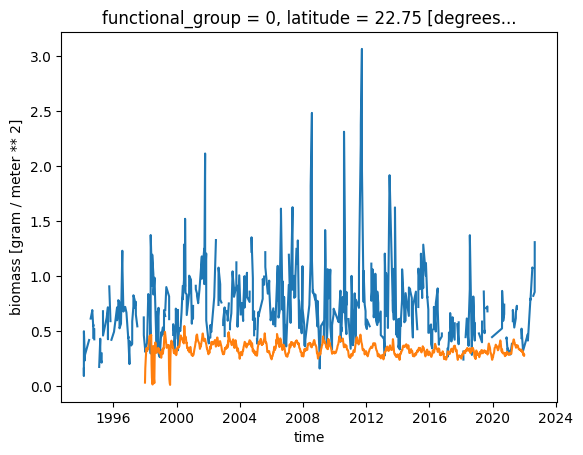

In [21]:
obs_hot.observation.day.pint.quantify().pint.to("g/m2").plot()
biomass_print.sel(latitude=22.75, longitude=-158, functional_group=0).pint.quantify().pint.to("g/m2").plot()